# Response analysis


##### 1. Response expression differential analysis - 
twice: (1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

##### 2. Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### 3. GEP association with response (1) -
Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

##### 4. GEP association with response (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    
    pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, n_groups+1)])], columns=['pval', 'group'])
    plt.figure(figsize=(8, 6), dpi=80);

    pvals = pvals_df[["group", "pval"]].values
    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));
        
def get_coorected_label(x ,p_value_dic):
    pvalue = p_value_dic[x]
    return str(x) + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])

def save_pvals(path, pvals, corrected_pvals, GROUP_NAME):
    pval_df = pd.DataFrame(np.array([pvals[:,0], pvals[:,1], corrected_pvals[:,1]]).T, columns=[GROUP_NAME, 'pval', 'corrected_pval'])#.sort_values('pval')
    pval_df[GROUP_NAME] = pval_df[GROUP_NAME].astype(int)
    pval_df.to_excel(path, index=False)


### Specify clinical table and set output path
clinical table can be 1|2|3
* 1 - NR mucosal vs NR cutaneous
* 2 - NR mucosal vs R cutaneous
* 3 - NR mucosal vs NR & R cutaneous

OUTPUT PATH - all marker list/heatmaps/figures will be saved there

In [3]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/subcohort_1.1.22/5.1.22_debug/NR_mucosal_vs_R_cutaneous'
CLINICAL_TABLE_NUM = 2

create_folder(FOLDER_PATH)

##### Loads clinical table to get labels - R/NR

In [4]:
# melanoma_clinical_data = get_clinical_data(ICI=True, after_biopsy='ICI')
melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #get_clinical_data(71)#ICI=True, after_biopsy='ICI')
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
display(melanoma_clinical_data.head(5))
res_melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv


,index,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI,BRAF
2,2,M99,Mucosal,NR,ICI,other therapy,True,False
14,14,M111,Mucosal,NR,ICI,other therapy,True,False
28,28,M128,Mucosal,NR,other therapy,ICI,True,False
30,30,M130,Cutaneous,R,other therapy,ICI,True,False
31,31,M131,Cutaneous,R,ICI,other therapy,True,False


R     5
NR    4
Name: response, dtype: int64

#### Builds response/non_response sample list

In [5]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number no label samples: {len(no_used_samples)}')

number reponse_samples: 5
number non_reponse_samples: 4
number no label samples: 0


#### Loads cohort's myeloid cells:

In [5]:
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/myeloid_normalized_26.6.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'

cohort = pickle.load(open(COHORT_PATH, 'rb'))

## 1. Myeloid\CD8 Differential expression analysis

In [6]:
GROUP = 'CYTOTOXIC_T_CELLS' # 'MYELOIDS' or 'CYTOTOXIC_T_CELLS'

from utilities.droplet_dataset import get_requested_subset
sub_cohort = get_requested_subset(cohort, GROUP)

In [85]:
response_samples_indices = [s in response_samples for s in sub_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in sub_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in sub_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_cells = sub_cohort[response_samples_indices]
non_response_samples_cells = sub_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 3141
number of cells in non_response_samples_indices: 2085
number of cells in no_used_samples_indices: 0


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [86]:
response_markers = find_marker_genes_in_cluster(response_samples_cells, non_response_samples_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in response samples: {len(response_markers)}')

Number of markers found in response samples: 329


#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [87]:
non_response_markers = find_marker_genes_in_cluster(non_response_samples_cells, response_samples_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in response samples: {len(non_response_markers)}')

Number of markers found in response samples: 65


#### Builds heatmap:

In [88]:
number_of_markers = 50

In [89]:
# arrange cells indices by mean expression
response_markers_indices = np.array([sub_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [sub_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [90]:
genes_indices = [sub_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']] + [sub_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

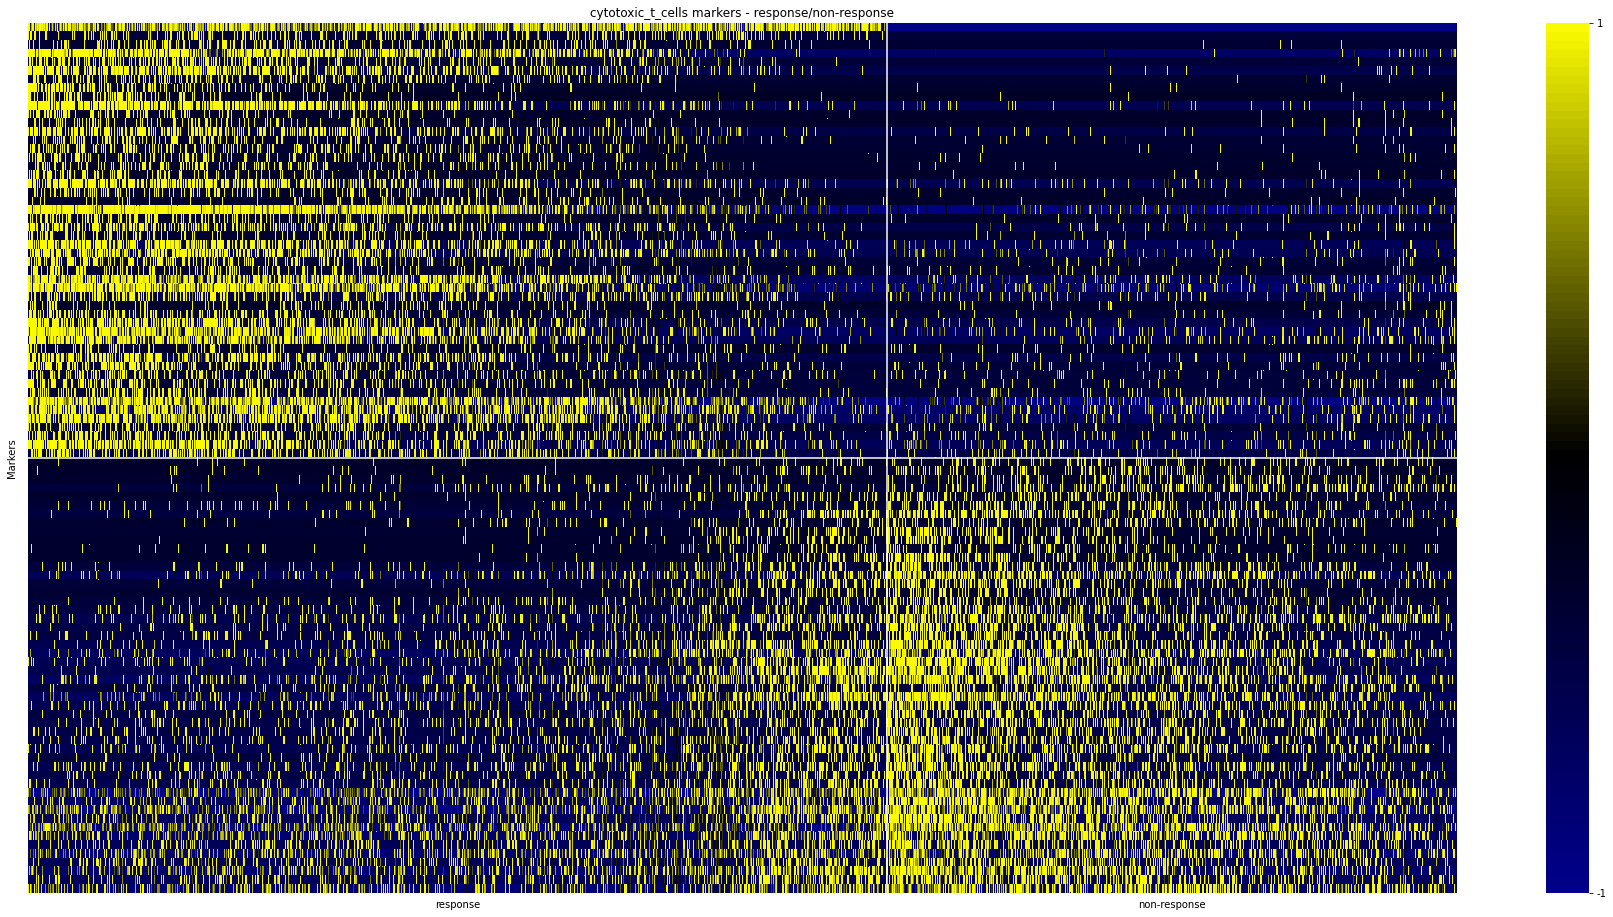

In [94]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
fig.set_size_inches(32, 16)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_cells.number_of_cells/2), response_samples_cells.number_of_cells+int(non_response_samples_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_cells.number_of_cells, color='white')
group_title = GROUP.lower()
ax.set_title(f"{group_title} markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [95]:
OUTPUT_PATH = join(FOLDER_PATH, f'{group_title}')
FILE_NAME = r'marker_heatmap.png'

create_folder(OUTPUT_PATH)
fig.savefig(join(OUTPUT_PATH, FILE_NAME))
response_markers.to_excel(join(OUTPUT_PATH, r'response_markers.xlsx'))
non_response_markers.to_excel(join(OUTPUT_PATH, r'non_response_markers.xlsx'))

folder: /storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/NR_mucosal_vs_R_cutaneous_29.11.21/cytotoxic_t_cells has been created


# 2. Myeloid clustering - Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [10]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [11]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [12]:
df = clusters_barcodes_mapping_df#.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [13]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=1.10377696422087, pvalue=0.2696898998450281)
WilcoxonResult(statistic=16.0, pvalue=0.49609375)


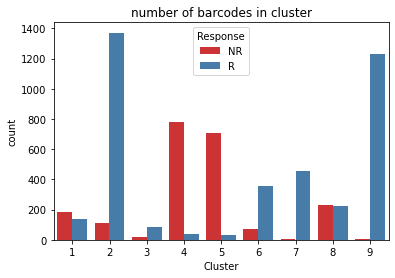

In [14]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=0.39735970711951313, pvalue=0.6911022238448428)
WilcoxonResult(statistic=22.0, pvalue=1.0)


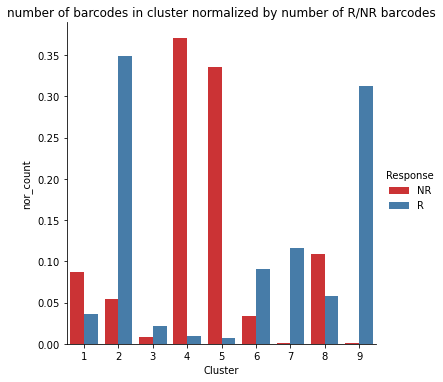

In [15]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=1.10377696422087, pvalue=0.2696898998450281)
WilcoxonResult(statistic=16.0, pvalue=0.49609375)


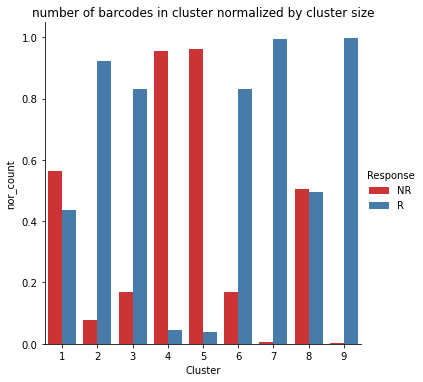

In [16]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

# 2.1. patient fraction over clusters - ranksum test

In [17]:
clusters = clusters_barcodes_mapping_df['Cluster'].unique()
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index()#.drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster'])#.drop(columns=['index'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

See how many samples (R/NR) have cells in each cluster:

In [18]:
# full_sample_fractions_df[["Sample", 'Cluster']].groupby('Cluster').count()
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

add zero fraction samples:

In [19]:
sample_fractions_df = sample_fractions_df[["Sample", 'Cluster', 'fraction' , 'Response' ]]
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    

visualize:

With corrected pvals!


<Figure size 480x240 with 0 Axes>

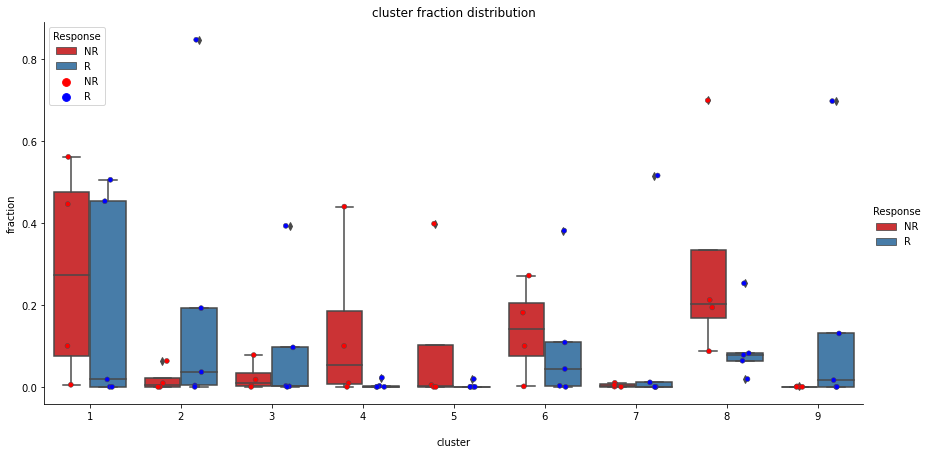

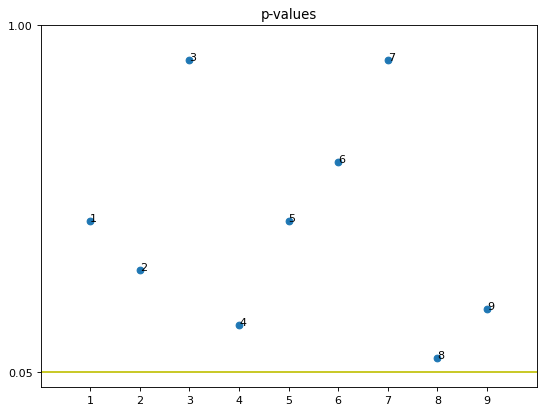

In [21]:
pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
print(f'With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

fig = plt.figure(figsize=(6, 3), dpi=80)
sns.reset_orig()
full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
sns.stripplot(x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

print_pvals(pvals[:,1], len(set(sample_fractions_df["Cluster"])))

In [17]:
# OUTPUT_PATH = join(FOLDER_PATH, 'myeloids', 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test.png'), dpi = 150)

# 2.2 myeloid clusters analysis - Fisher exact's test

With corrected pvals!


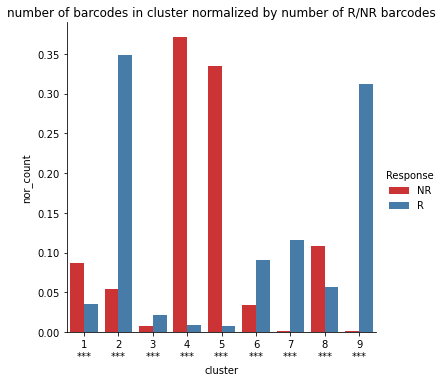

In [23]:
n_cells_in_group_df = df.groupby(['Response']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Response']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='R')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='R']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='NR')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='NR']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    pvals.append([cluster_idx, pvalue])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

# print_pvals(pvals[:,1], 11)
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR
# print('Normalized by number of barcodes in group (R/NR):')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
count_df['cluster'] = count_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="bar", x='cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')

In [19]:
# OUTPUT_PATH = join(FOLDER_PATH, 'myeloids', 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'clustering_fisher_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'clustering_fisher_test.png'), dpi = 150)

# 3. CD8 clustering - Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [24]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/subcohort_1.1.22_run_1.1.22/subcohort_CD8_1.1.22_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [25]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [26]:
df = clusters_barcodes_mapping_df#.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [27]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=0.5222329678670935, pvalue=0.6015081344405899)
WilcoxonResult(statistic=6.0, pvalue=0.8125)


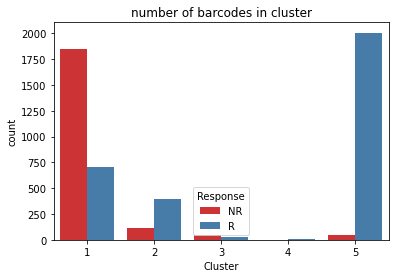

In [28]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=0.3133397807202561, pvalue=0.7540225300620748)
WilcoxonResult(statistic=7.0, pvalue=1.0)


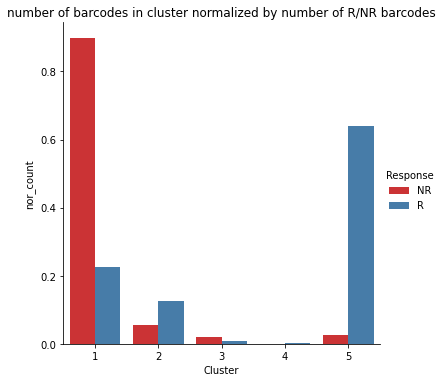

In [29]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=1.775592090748118, pvalue=0.07580017458236125)
WilcoxonResult(statistic=3.0, pvalue=0.3125)


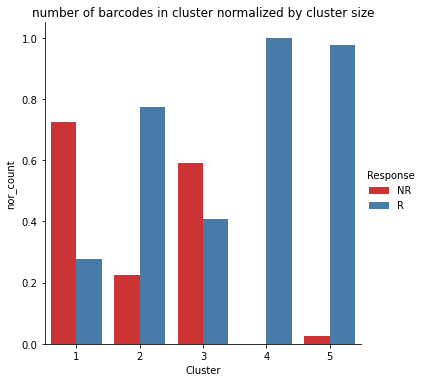

In [30]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

# 3.1. CD8  clustering - patient fraction over clusters - ranksum test

In [34]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster'])#.drop(columns=['index'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

See how many samples (R/NR) have cells in each cluster:

In [35]:
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

Add zero fraction samples:

In [36]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    

Visualize:

With corrected pvals!


<Figure size 480x240 with 0 Axes>

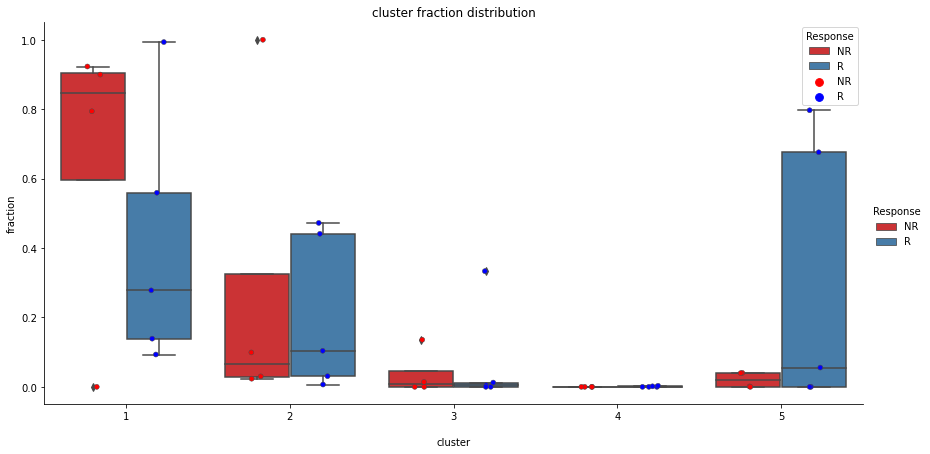

<Figure size 480x240 with 0 Axes>

In [42]:
sample_fractions_df = sample_fractions_df[["Sample", 'Cluster', 'fraction' , 'Response' ]]
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
print(f'With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

sns.reset_orig()
full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df.sort_values('Cluster'), palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
sns.stripplot(x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df.sort_values('Cluster'),
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
plt.figure(figsize=(6, 3), dpi=80)
# print_pvals(corrected_pvals[:,1], len(set(sample_fractions_df["Cluster"])))

In [31]:
# OUTPUT_PATH = join(FOLDER_PATH, 'cytotoxic_t_cells', 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test.png'), dpi = 150)

# 3.2 CD8 cluster analysis - Fisher exact's test

With corrected pvals!


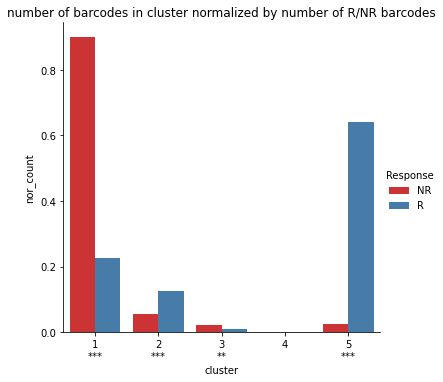

In [44]:
n_cells_in_group_df = df.groupby(['Response']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Response']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='R')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='R']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='NR')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='NR']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    pvals.append([cluster_idx, pvalue])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR
# print('Normalized by number of barcodes in group (R/NR):')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
count_df['cluster'] = count_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="bar", x='cluster', y='nor_count', hue='Response', data=count_df.sort_values('cluster'), palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')

In [33]:
# OUTPUT_PATH = join(FOLDER_PATH, 'cytotoxic_t_cells', 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'clustering_fisher_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'clustering_fisher_test.png'), dpi = 150)

## Examining siginificance difference with differnt values of K in CD8:

In [34]:
# select K
K = 2
folder = 'CD8'


print(f'{folder} clustering')
print(f'K={K}')
clusters_barcodes_mapping_path = fr'/storage/md_keren/shitay/outputs/clustering/{folder}/kmeans/cohort_26.6.21_run_11.8.21/barcode_mapping/kmeans_immune_cells_4k_genes_k_{K}_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

df = clusters_barcodes_mapping_df.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']


clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])



full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)


##################################################
################# Correct pvals ##################
##################################################

# pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], K)
# pvals

CD8 clustering
K=2


KeyError: 'M100'

# Debug

(array([3.14172e+05, 1.56600e+03, 3.33000e+03, 5.62600e+03, 5.96800e+03,
        3.52000e+03, 1.42100e+03, 5.09000e+02, 8.50000e+01, 1.00000e+01]),
 array([0.        , 0.6177036 , 1.23540719, 1.85311079, 2.47081438,
        3.08851798, 3.70622157, 4.32392517, 4.94162876, 5.55933236,
        6.17703595]),
 <BarContainer object of 10 artists>)

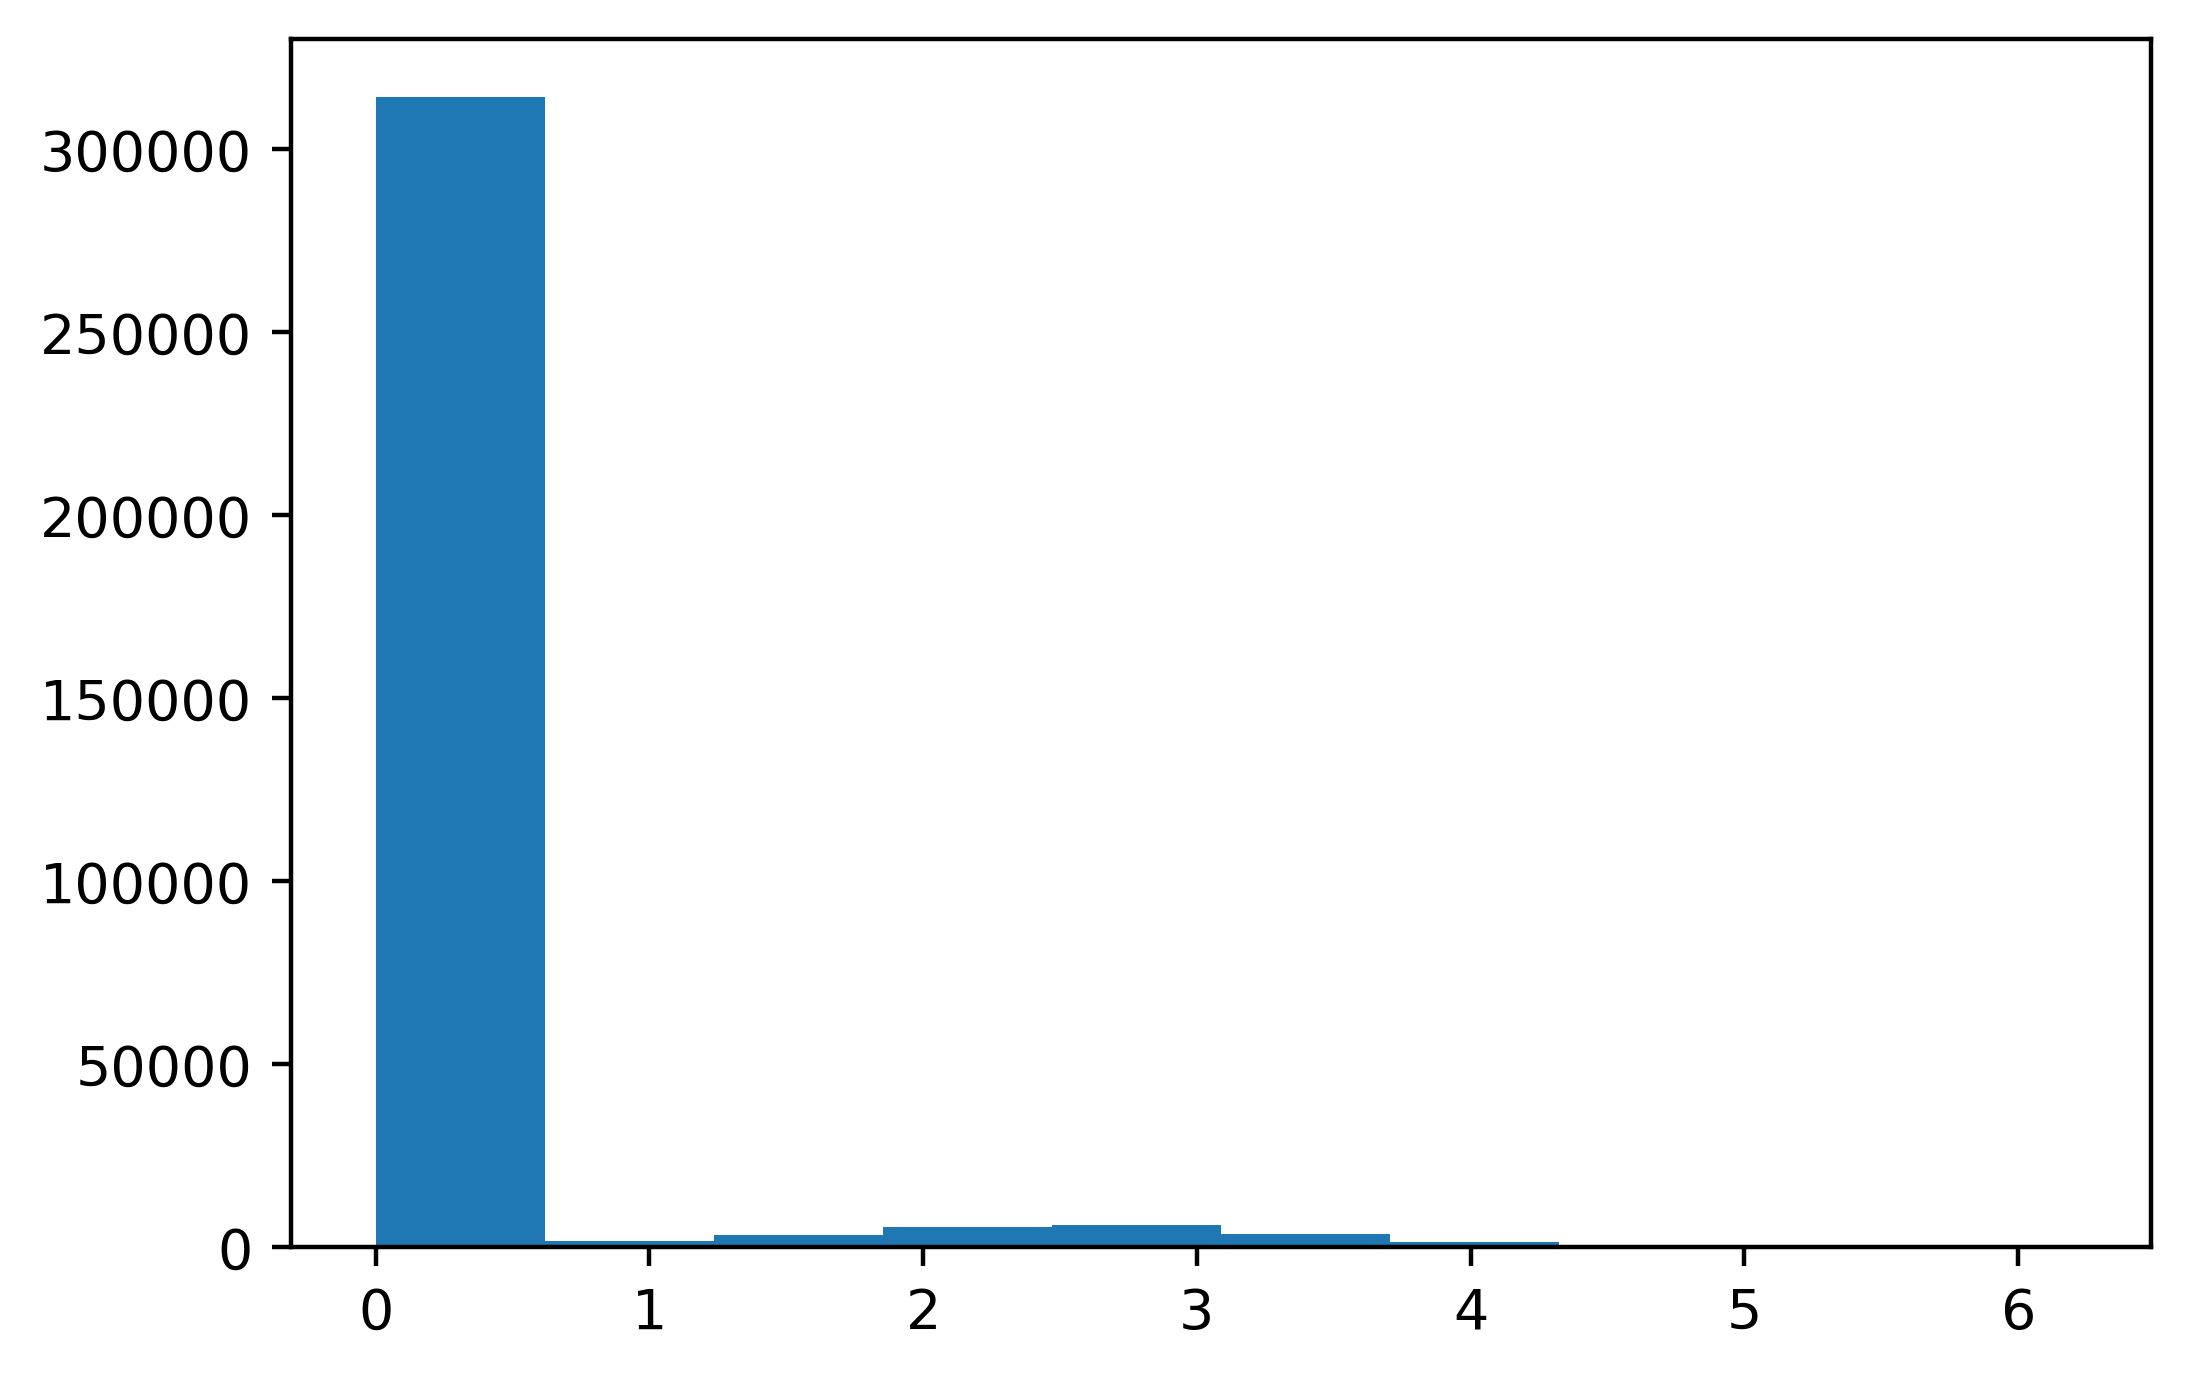

In [21]:
plt.hist(cohort.counts[:, cohort.gene_names.index('CTLA4')])

In [61]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_OCT_unportected.xlsx'
# MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'

melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

display(clinical_labels.head(3))
display(melanoma_clinical_data.head(1))

,Clinical response,binary label,number of samples
0,NR,NR,6
1,NR (PD),NR,6
2,??,not in use for now,6


,#,Patient id,MGH id,Date collected,Sex (F/M),Age (relevant to time of sample),Melanoma type,Primary=1; Metastasis=0,Genotype,Therapy(ies) prior to biopsy,Therapy after biopsy,Clinical response,Status (Alive=1/Dead=0),Biopsy site,"Biopsy type (pre, post)",Overall survival (days),Comments,Cell line (Y; N),TILs (Y; N)
0,1,M97,1256,2019-10-11,M,79.0,Cutaneous,0,TP63; DDR2; ATM; MAP2K1; HNF1A; TERT,NaN,PD1 (started on 3/31/20),R,1.0,Left Axillary LN,Pre,NaN,NaN,NaN,NaN


In [62]:
# takes only first 71 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:71][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data.head(3)

,Patient id,Clinical response,Melanoma type
0,M97,R,Cutaneous
1,M98,R (had a response in 2016-2019),Cutaneous
2,M99,NR (PD),Mucosal


In [64]:
# fill Nans
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')

# label mapping using clinical_label table 
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
labels_mapping['R '] = 'R'
labels_mapping['PD (NR; for pembro) NR for d+t'] = 'NR'
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])

melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other', '??':'other'}
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])
pd.set_option('display.max_rows', None)



In [70]:
# display(melanoma_clinical_data.iloc[46:])
melanoma_clinical_data.iloc[46:]['response'].value_counts()
melanoma_clinical_data.iloc[46:]['Melanoma type'].value_counts()

Cutaneous    18
other         7
Name: Melanoma type, dtype: int64

In [87]:
melanoma_clinical_data.iloc[:71].groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['Clinical response']).

,Melanoma type,response,Patient id
0,Cutaneous,NR,23
1,Cutaneous,R,15
2,Cutaneous,not in use for now,11
3,Mucosal,NR,5
4,Mucosal,R,2
5,Mucosal,not in use for now,1
6,other,NR,4
7,other,R,3
8,other,not in use for now,7


With corrected pvals!
cluster = 1,	ratio = 1.035,	diff = 0.0026,	pval<0.05= False,	condition = False
cluster = 2,	ratio = 1.333,	diff = 0.0012,	pval<0.05= False,	condition = False
cluster = 3,	ratio = 1.485,	diff = 0.0091,	pval<0.05= True,	condition = False
cluster = 4,	ratio = 134.922,	diff = 2.1807,	pval<0.05= True,	condition = True
cluster = 5,	ratio = 1.886,	diff = 0.0349,	pval<0.05= True,	condition = True
cluster = 6,	ratio = 102.891,	diff = 0.4852,	pval<0.05= True,	condition = True
cluster = 7,	ratio = 20.601,	diff = 0.005,	pval<0.05= True,	condition = True
cluster = 8,	ratio = 2.558,	diff = 0.0486,	pval<0.05= True,	condition = True
cluster = 9,	ratio = 1.37,	diff = 0.0235,	pval<0.05= True,	condition = False
cluster = 10,	ratio = 81.518,	diff = 0.4992,	pval<0.05= True,	condition = True
cluster = 11,	ratio = 4.771,	diff = 0.0489,	pval<0.05= True,	condition = True
Normalized by number of barcodes in group (R/NR):


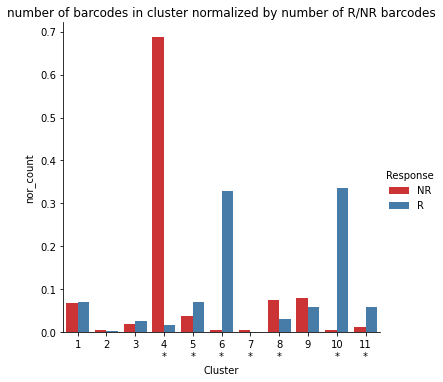

In [28]:
##### Condition added ######

n_cells_in_group_df = df.groupby(['Response']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Response']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
ratios = []
diffs = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='R')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='R']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Response']=='NR')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Response']=='NR']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    
    g1_r = (n_cells_g1_in_cluster / n_cells_g1_not_in_cluster)
    g2_r = (n_cells_g2_in_cluster / n_cells_g2_not_in_cluster)
    diff = abs(g1_r - g2_r)
    ratio = abs(max(g1_r, g2_r) / min(g1_r, g2_r))

    condition = pvalue < 0.05 and (ratio > 1.5 or diff > 0.1)
    
    
    pvals.append(pvalue)
    ratios.append(ratio)
    diffs.append(diff)
#     print(f'cluster = {cluster_idx},\tratio = {round(ratio,3)},\tdiff = {round(diff,4)},\tpvalue = {round(pvalue,4)},\tconidtion = {condition}')
pvals = np.array(pvals)
ratios = np.array(ratios)
diffs = np.array(diffs)

# Correct pvals
print('With corrected pvals!')
pvals = multipletests_fdr(pvals)[1] < 0.05
condition = pvals & (ratios > 1.5) | (diffs > 0.1)
tr_lbl = {True: '*', False:''}

for i in sorted(df['Cluster'].unique().tolist()):
    print(f'cluster = {i},\tratio = {round(ratios[i-1],3)},\tdiff = {round(diffs[i-1],4)},\tpval<0.05= {pvals[i-1]},\tcondition = {condition[i-1]}')


R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR
print('Normalized by number of barcodes in group (R/NR):')
count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
count_df['Cluster'] = count_df['Cluster'].apply(lambda x: str(x)+'\n'+tr_lbl[condition[x-1]])
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
 